# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)
- 24/11/2023:
    - Included loading of document loader cache options
    - [ ] Consider document loader cache options in analysis

---


In [116]:
import os
import json
import git
import re
import numpy as np
np.random.seed(42)
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-26T00:49:01'

Plot config

In [2]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [3]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


def read_json(fpath: str) -> dict:
    return json.loads(open(fpath, 'r').read())

def parse_js_timestamp(jsts: int):
    """Parse timestamps created using JS/TS's `Date.now()`.
    Ref: https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now
    """
    return datetime.datetime.utcfromtimestamp(jsts/1000)


## Input data

WIP: incorporating multi-actor profiling reports with varying document loader option configurations.

Note: timestamps were created using JS/TS's `Date.now()`.

> The Date.now() static method returns the number of milliseconds elapsed since the epoch, which is defined as the midnight at the beginning of January 1, 1970, UTC.

<https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Date/now>

In [4]:
def create_report_df(s_json_report_files: pd.Series) -> pd.DataFrame:
    """v20231125 - expects pd.Series containing the paths to the multi-actor report (JSON).
    These reports are expected to also include other metadata (e.g. document loader cache option configuration)
    Returns pd.DataFrame from parsed records
    """
    # Split filpaths into a parentdir & the basename of the json file
    df_files = s_json_report_files.apply(os.path.split).apply(pd.Series)
    df_files.columns = ['parent_dir','basename']
    df_files['fpath'] = s_json_report_files
    # Parse the timestamps (cfr. Date.now() in JS/TS)
    df_files['parent_dir_ts'] = df_files.parent_dir.apply(os.path.basename).astype(int).apply(parse_js_timestamp)
    df_files['report_ts'] = df_files.basename.str.replace('.json','').apply(lambda x: x.split('-')[-1]).astype(int).apply(parse_js_timestamp)

    # Read JSON files into a dataframe
    _df = df_files.iloc[:].fpath.apply(read_json).apply(pd.Series)
    # Process Document Loader Cache Options
    _df_dlco = _df['documentLoaderCacheOptions'].apply(pd.Series).stack().apply(pd.Series).unstack(1).swaplevel(axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    _df_dlco.index.set_names('idx_report',inplace=True)
    # Flatten columns
    _df_dlco.columns = list(map(lambda t: '_'.join(t), _df_dlco.columns))

    # Process multi actor records
    _df_records = _df.records.apply(pd.Series).stack()
    _df_records.index.set_names(['idx_report','idx_step'],inplace=True)
    _df_records = _df_records.apply(pd.Series).drop('index',axis=1)
    
    # Combine
    _df_result = pd.concat({'report': _df_records,}, axis=1).merge(pd.concat({'dlco':_df_dlco}, axis=1), left_index=True, right_index=True)
    assert _df_result.shape[0] == _df_records.shape[0] # sanity check
    
    # Column renaming
    _df_result.rename({'tag': 'actorTag', 'name': 'stepName', },axis=1,inplace=True)
    _df_result[('report','actorStep')] = _df_result.apply(lambda r: f'{r.report.actorTag}.{r.report.stepName}',axis=1)
    _df_result.sort_index(axis=1,inplace=True)
    return _df_result
    

## Analysis

In [5]:
AGG_FUNCTIONS = ['median','mean', 'std', 'min','max','count',pd.Series.skew, pd.Series.kurt]

---

In [6]:
#df = get_df()
df = create_report_df(pd.Series(glob('./reports/profiling/*/*.json')))
df.shape

(38676, 10)

In [7]:
df.head(3)

dlco  \
                    DID_cacheResolvedDIDDocs   
idx_report idx_step                            
0          0                           False   
           1                           False   
           2                           False   

                                                                          \
                    HTTP_cacheWebResourcesResolvedFromLocalHostInstances   
idx_report idx_step                                                        
0          0                                                     False     
           1                                                     False     
           2                                                     False     

                                                              \
                    HTTP_cacheWebResourcesResolvedFromTheWeb   
idx_report idx_step                                            
0          0                                           False   
           1                                           False   
           2                                           False   

                                                  report              \
                                               actorStep    actorTag   
idx_report idx_step                                                    
0          0          university.createDiplomaCredential  university   
           1            university.signDiplomaCredential  university   
           2         government.createIdentityCredential  government   

                                                                       \
                        className delta            end          start   
idx_report idx_step                                                     
0          0         SolidVCActor     0  1700851594271  1700851594271   
           1         SolidVCActor   511  1700851594782  1700851594271   
           2         SolidVCActor     0  1700851594782  1700851594782   

                                               
                                     stepName  
idx_report idx_step                            
0          0          createDiplomaCredential  
           1            signDiplomaCredential  
           2         createIdentityCredential

### Task-level

The reports will be considered in groups, divided by the following group columns:
    
- `actorTag`: the name/tag of an actor within the context of the use case (e.g. alice)
- `className`: the classname of an actor's implementation (e.g. `SolidVCACtor`)
- `actorStep` the profiled step/action taken by the actor (e.g. `verifyPresentation`)

In [169]:
def equalize_groupsizes(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    grpr = df.groupby(group_columns)
    n_smallest_group = grpr.size().min()
    idx_to_drop = []
    for i,g_idx in grpr.groups.items():
        ni_idx_to_drop = g_idx.size - n_smallest_group
        np.random.seed(42)
        idx_to_drop.append(np.random.choice(g_idx,size=ni_idx_to_drop))

    idx_to_drop = np.concatenate(idx_to_drop)
    return df.drop(index=idx_to_drop)

In [172]:

# Add phases
phase_steps = {
    'pre-evaluation': [
        'university.createDiplomaCredential',
        'university.signDiplomaCredential',
        'government.createIdentityCredential',
        'government.signIdentityCredential',
    ],
     'phase-1': [
        'alice.deriveDiplomaCredential',
        'alice.createPresentation01',
        'alice.signPresentation01',
        'recruiter.verifyPresentation01'
    ],
    'phase-2': [
        'alice.deriveIdentityCredential',
        'alice.createPresentation02',
        'alice.signPresentation02',
        'recruiter.verifyPresentation02'
    ],
}
df_phase_steps = pd.Series(phase_steps)\
    .apply(pd.Series)\
    .stack()\
    .to_frame('actorStep')\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename({'level_0': 'phase'}, axis=1)
# Create multi-index (for later)
df_phase_steps = pd.concat({'report':df_phase_steps},axis=1)
# sanity check: make sure that actorSteps exactly match
x = set(df.report.actorStep.value_counts(dropna=False).index)
y = set(df_phase_steps.report.actorStep.value_counts().index)
assert len(x-y) == 0
df_phase_steps.head(3)

# merge df with phases back to df_tl
df_tl = df.reset_index().merge(df_phase_steps, on=[('report','actorStep')])

# Log(1+delta) transform to get a "more Gaussian" distribution
df_tl[('report','delta_log1p')] = df_tl[('report','delta')].apply(np.log1p)

# Equalize group sizes
df_tl = equalize_groupsizes(df_tl, GROUP_COLUMNS)

df_tl

idx_report idx_step                     dlco                                                                                                                            report                                                                                                                   
                          DID_cacheResolvedDIDDocs HTTP_cacheWebResourcesResolvedFromLocalHostInstances HTTP_cacheWebResourcesResolvedFromTheWeb                           actorStep    actorTag     className delta            end          start                 stepName           phase delta_log1p
0              0        0                    False                                                False                                    False  university.createDiplomaCredential  university  SolidVCActor     0  1700851594271  1700851594271  createDiplomaCredential  pre-evaluation    0.000000
1              1        0                    False                                                False                                    False  university.createDiplomaCredential  university  SolidVCActor     0  1700854579769  1700854579769  createDiplomaCredential  pre-evaluation    0.000000
2              2        0                    False                                                False                                    False  university.createDiplomaCredential  university  SolidVCActor     0  1700854859296  1700854859296  createDiplomaCredential  pre-evaluation    0.000000
3              3        0                    False                                                False                                    False  university.createDiplomaCredential  university    DidVCActor     0  1700858484033  1700858484033  createDiplomaCredential  pre-evaluation    0.000000
4              4        0                    False                                                False                                    False  university.createDiplomaCredential  university  SolidVCActor     0  1700858507094  1700858507094  createDiplomaCredential  pre-evaluation    0.000000
...          ...      ...                      ...                                                  ...                                      ...                                 ...         ...           ...   ...            ...            ...                      ...             ...         ...
38671       3218       11                     True                                                False                                    False      recruiter.verifyPresentation02   recruiter  SolidVCActor   349  1700861554094  1700861553745     verifyPresentation02         phase-2    5.857933
38672       3219       11                     True                                                False                                    False      recruiter.verifyPresentation02   recruiter    DidVCActor   794  1700865359652  1700865358858     verifyPresentation02         phase-2    6.678342
38673       3220       11                     True                                                False                                    False      recruiter.verifyPresentation02   recruiter    DidVCActor   760  1700865757610  1700865756850     verifyPresentation02         phase-2    6.634633
38674       3221       11                     True                                                False                                    False      recruiter.verifyPresentation02   recruiter  SolidVCActor   389  1700864398803  1700864398414     verifyPresentation02         phase-2    5.966147
38675       3222       11                     True                                                False                                    False      recruiter.verifyPresentation02   recruiter  SolidVCActor   415  1700864030011  1700864029596     verifyPresentation02         phase-2    6.030685

[38664 rows x 14 columns]

#### Nr. reports

In [173]:
assert df_tl.groupby(['idx_report',]).count().stack([0,1]).unique().__len__() == 1 # sanity check: equal nr of samples per group
# nr reports
N = df_tl.idx_report.unique().__len__()
N

/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_15488/89981526.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assert df_tl.groupby(['idx_report',]).count().stack([0,1]).unique().__len__() == 1 # sanity check: equal nr of samples per group


3222

#### Sample groups

In [174]:
# grouper object for the reports
grpr = df_tl.groupby(GROUP_COLUMNS)
grpr

In [175]:
GROUPS = list(grpr.groups.keys())

##### Group sizes

In [177]:
grpr.size()

(report, actorTag)  (report, className)  (report, actorStep)                
alice               DidVCActor           alice.createPresentation01             1611
                                         alice.createPresentation02             1611
                                         alice.deriveDiplomaCredential          1611
                                         alice.deriveIdentityCredential         1611
                                         alice.signPresentation01               1611
                                         alice.signPresentation02               1611
                    SolidVCActor         alice.createPresentation01             1611
                                         alice.createPresentation02             1611
                                         alice.deriveDiplomaCredential          1611
                                         alice.deriveIdentityCredential         1611
                                         alice.signPresentation01        

---

In [179]:
# sanity check: assert that the same number of samples, for each group!
if not grpr.size().value_counts().shape[0] != 0:
    raise Warning('Groups do not have an equal number of samples!')

df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

In [180]:
# Make sure that every report has the same number of actor steps
assert (df_tl.reset_index().groupby('idx_report').count() == 12).all().all()

/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_15488/1571744100.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  assert (df_tl.reset_index().groupby('idx_report').count() == 12).all().all()


In [181]:
# df_stepname_order is used to specify the order of plots
df_stepname_order = df_tl.set_index(['idx_report','idx_step']).report.reset_index().reset_index()[['idx_step','stepName','actorTag','actorStep','phase']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag,actorStep,phase
0,0,createDiplomaCredential,university,university.createDiplomaCredential,pre-evaluation
3222,1,signDiplomaCredential,university,university.signDiplomaCredential,pre-evaluation
6444,2,createIdentityCredential,government,government.createIdentityCredential,pre-evaluation
9666,3,signIdentityCredential,government,government.signIdentityCredential,pre-evaluation
12888,4,deriveDiplomaCredential,alice,alice.deriveDiplomaCredential,phase-1
16110,5,createPresentation01,alice,alice.createPresentation01,phase-1
19332,6,signPresentation01,alice,alice.signPresentation01,phase-1
22554,7,verifyPresentation01,recruiter,recruiter.verifyPresentation01,phase-1
25776,8,deriveIdentityCredential,alice,alice.deriveIdentityCredential,phase-2
28998,9,createPresentation02,alice,alice.createPresentation02,phase-2


In [182]:
VAR_X = 'delta_log1p'

In [183]:
kwargs_violinplot = dict(
    x=VAR_X,
    y='actorStep',
    hue='className'
)

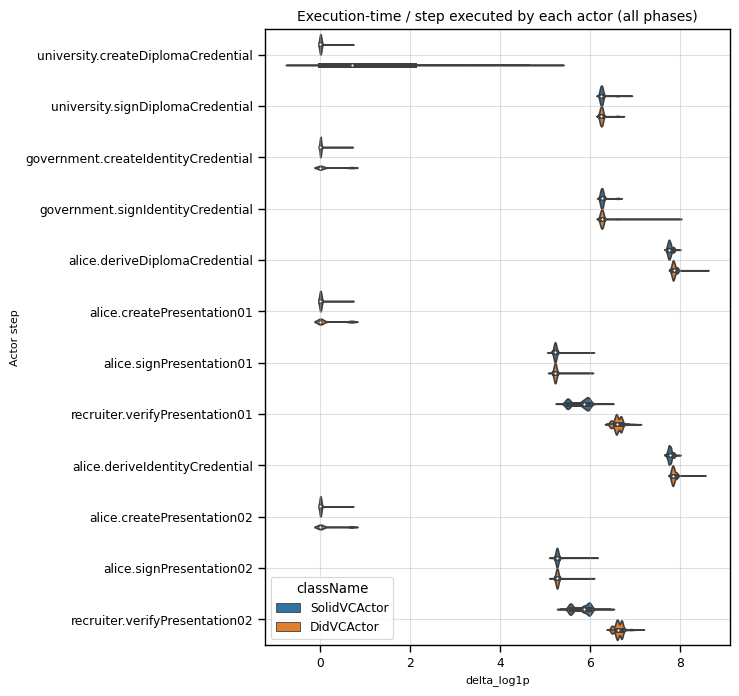

In [187]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (all phases)'
ax = sns.violinplot(df_tl.report,
                    **kwargs_violinplot,
                    order=df_stepname_order['actorStep'],
                    tight_layout=True,
                    ax=ax)
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(f'{kwargs_violinplot["x"]}')
ax.grid(alpha=.4)

plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-all-phases.png'),pad_inches=.5)
plt.show()

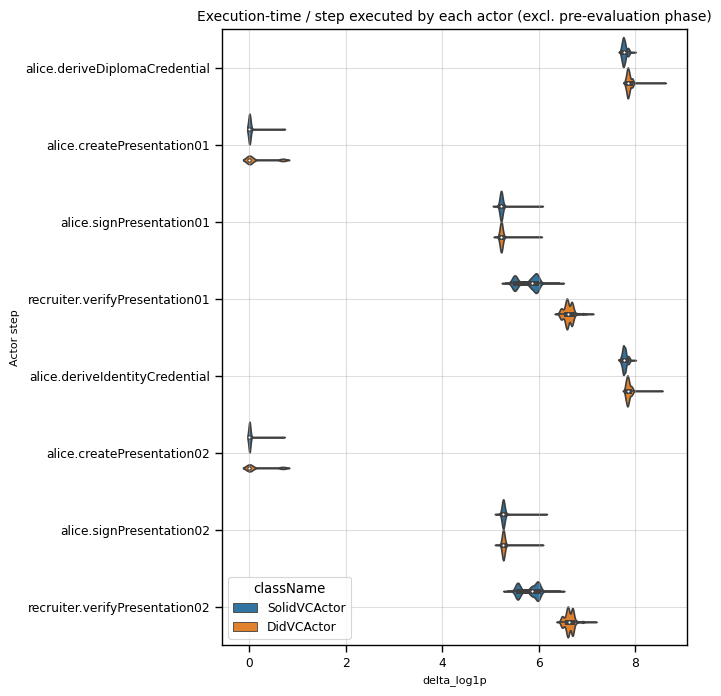

In [188]:
f, ax = plt.subplots(1,1, figsize=(6,8))
title = f'Execution-time / step executed by each actor (excl. pre-evaluation phase)'
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
order_data = df_stepname_order[df_stepname_order.phase != 'pre-evaluation']['actorStep']
ax = sns.violinplot(snsdata,
                    **kwargs_violinplot,
                    order=order_data,
                    tight_layout=True,
                    ax=ax,
                   )
ax.set_title(title)
ax.set_ylabel('Actor step')
ax.set_xlabel(VAR_X)
ax.grid(alpha=.4)
plt.savefig(os.path.join(DIR_REPORT,'violonplot-execution-time-per-actor-step-excl-pre-evaluation-phase.png'),pad_inches=.5)
plt.show()

In [189]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']

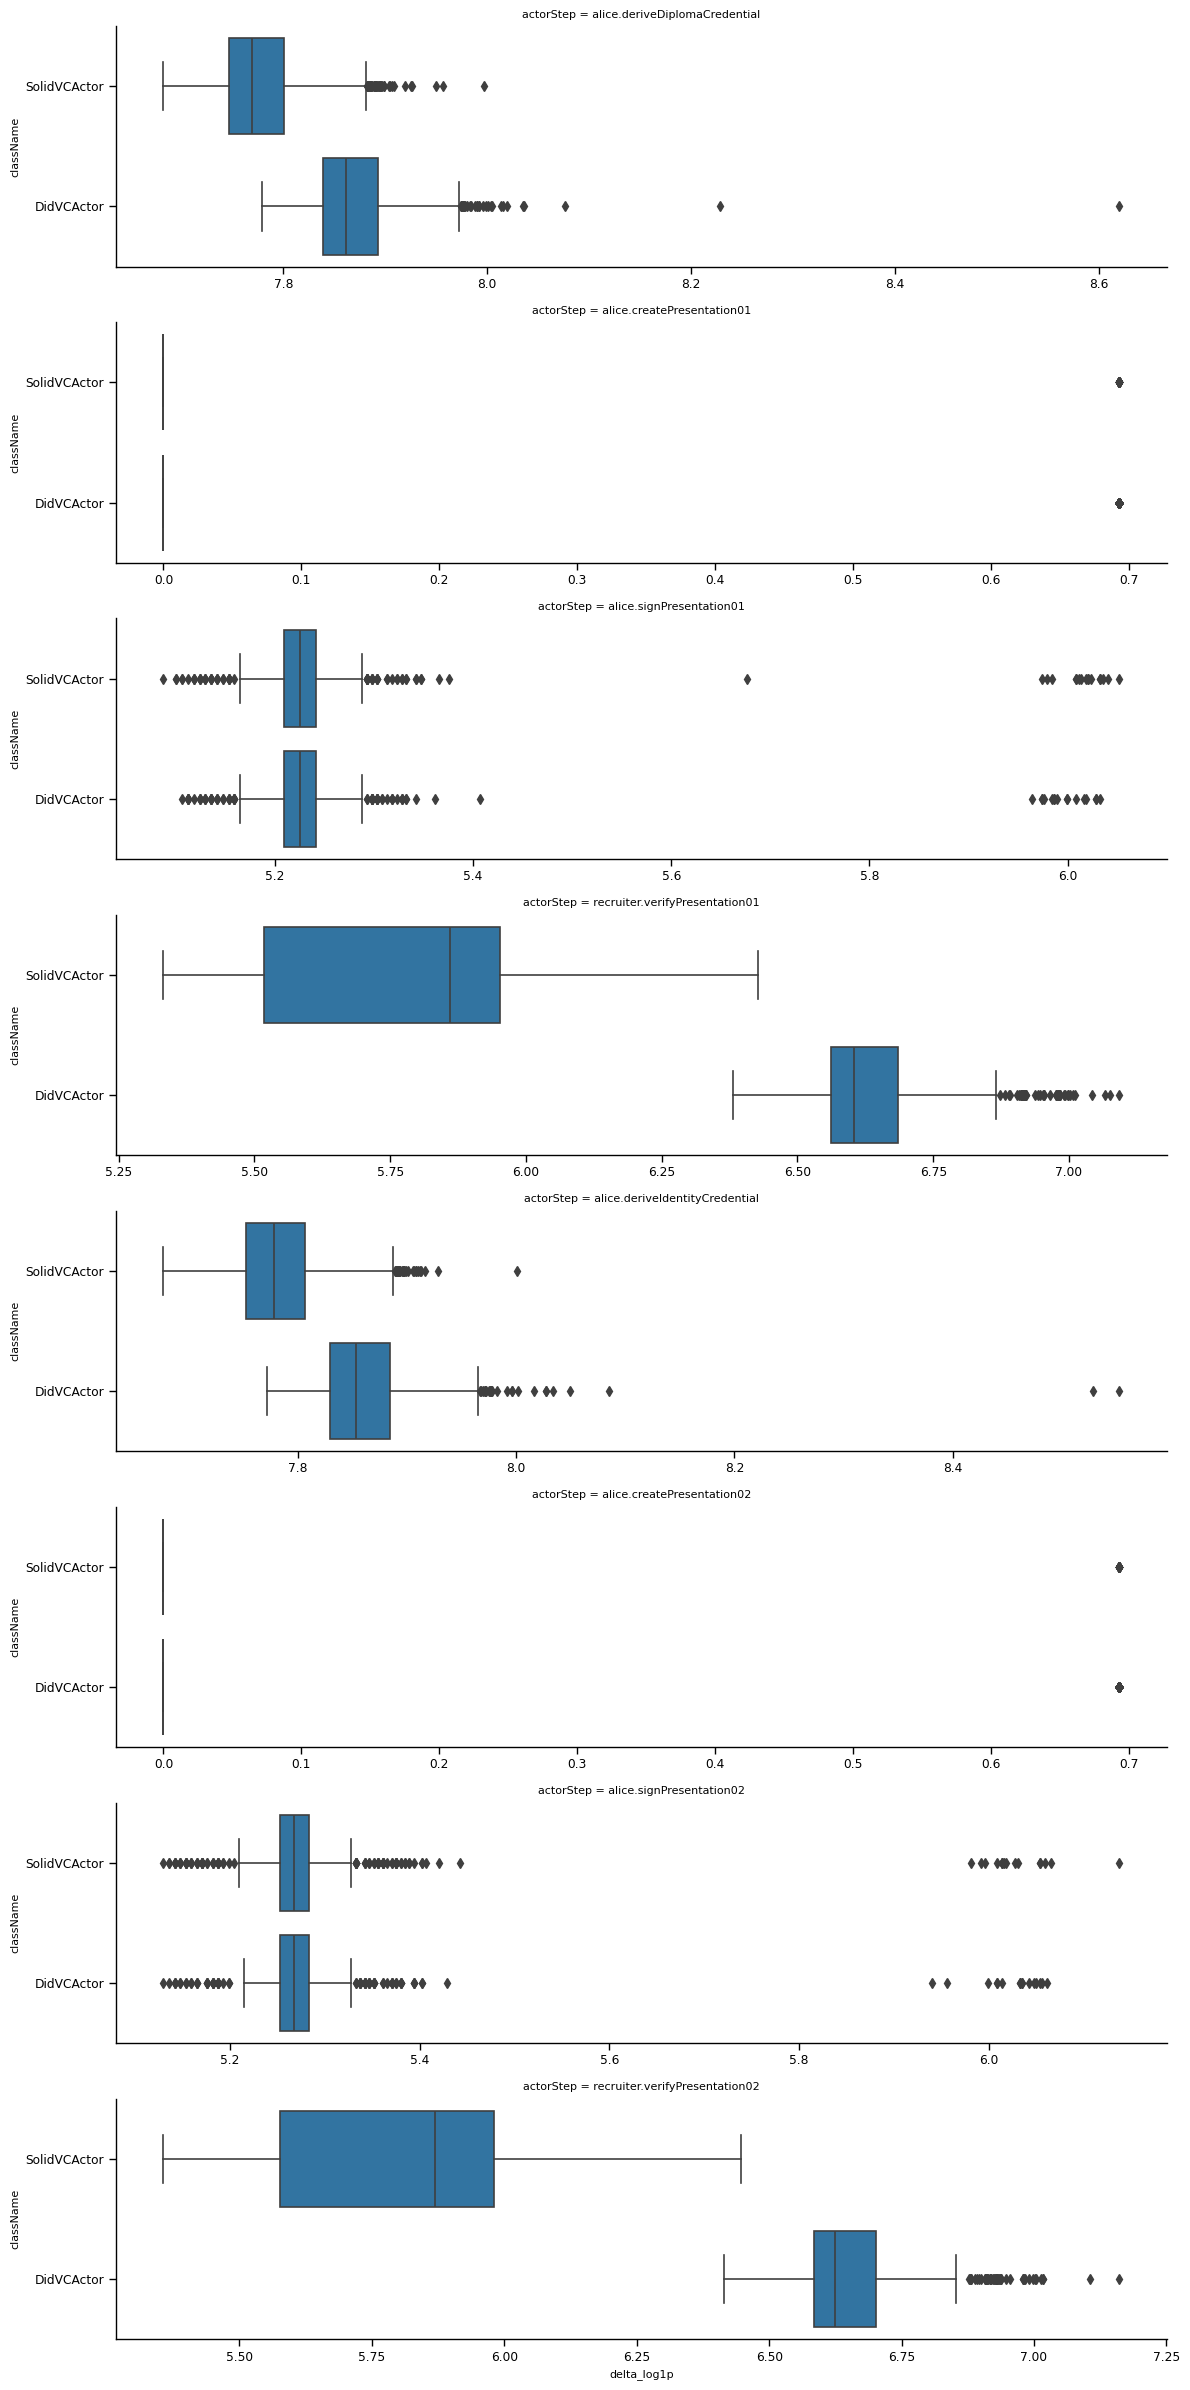

In [190]:
g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.boxplot, x=VAR_X, y='className')
plt.show()

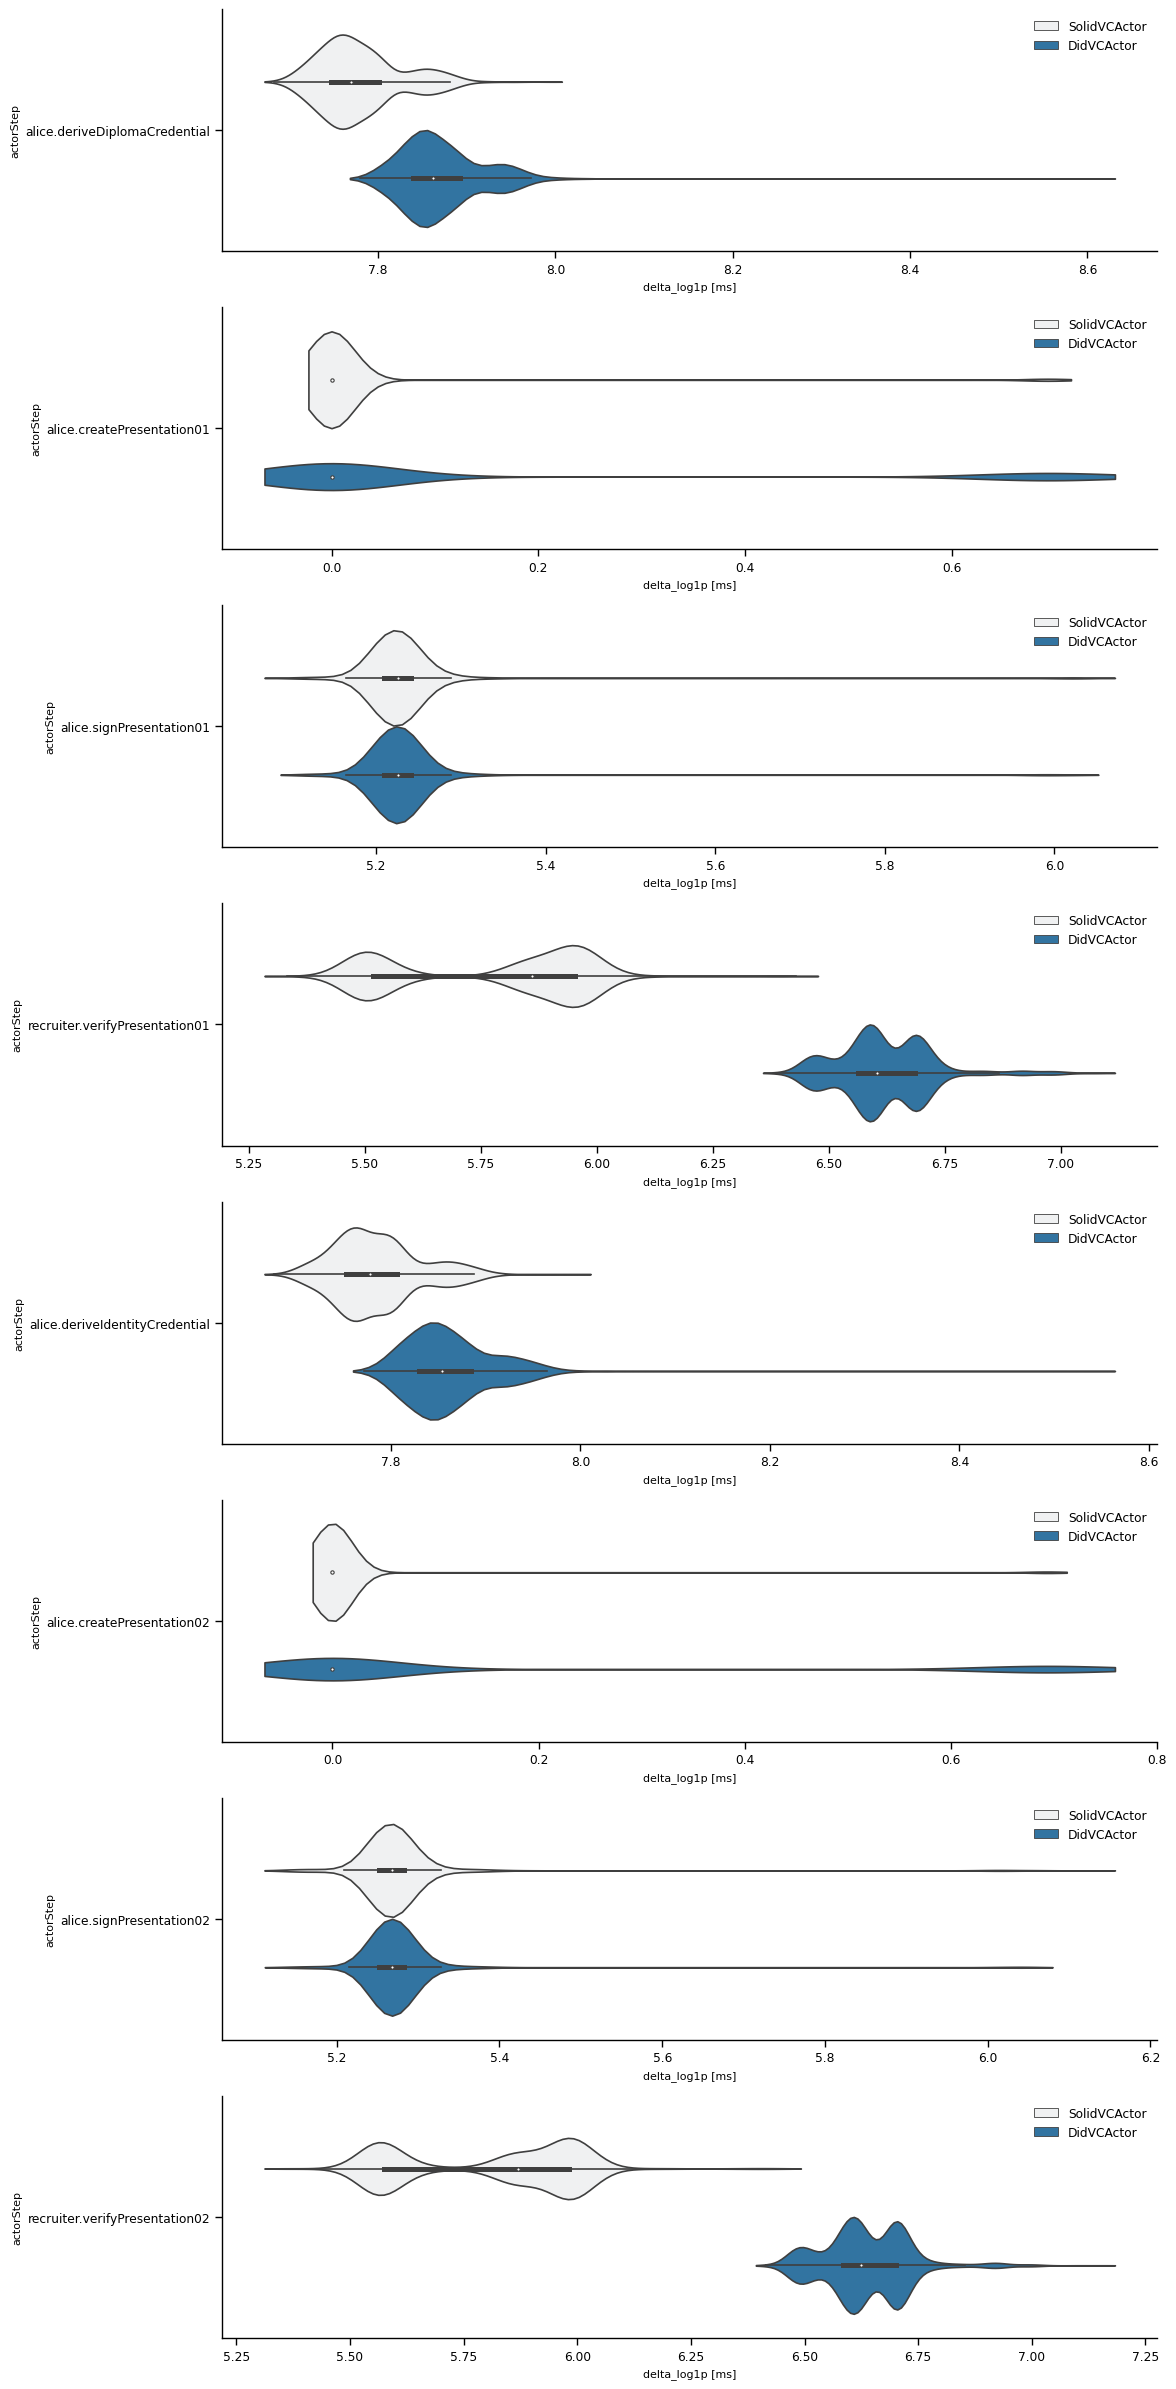

In [191]:
snsdata = df_tl.report[df_tl.report.phase != 'pre-evaluation']
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)

g = sns.FacetGrid(snsdata,col='actorStep',col_wrap=1, sharex=False, sharey=False, aspect=4)
g.map_dataframe(sns.violinplot,
                **kwargs_violinplot,
                #inner='point',
                #inner='quart',
#                split='quart',
                cut=1,
                inner_kws=dict(box_width=15, whis_width=2, color=".8")

                
               )
# Create main legend
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    ax.set_title('')
    # Add a copy of the main legend to each subplot
    ax.legend(handles=g.legend.legend_handles,frameon=False)

# Hide main legend
g.legend.set_visible(False)
g.tight_layout()
plt.show()

Compute & export aggregate statistics

In [192]:
# name refers to the function/step name
df_tl_agg = df_tl.report.groupby(['actorTag','className','stepName'])[['delta']].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 8)

In [193]:
df_tl_agg.unstack('className').swaplevel(1,2,axis=1).sort_index(axis=1)

delta                                                                                                                                                     
className                           DidVCActor                                                                     SolidVCActor                                                                    
                                         count        kurt   max         mean  median   min       skew         std        count        kurt   max         mean  median   min       skew         std
actorTag   stepName                                                                                                                                                                                
alice      createPresentation01           1611   -0.054369     1     0.214153     0.0     0   1.394883    0.410361         1611   43.979194     1     0.020484     0.0     0   6.776769    0.141693
           createPresentation02           1611   -0.234234     1     0.223464     0.0     0   1.328931    0.416696         1611   62.337150     1     0.014898     0.0     0   8.016219    0.121181
           deriveDiplomaCredential        1611  112.746064  5539  2621.913718  2595.0  2390   6.187441  141.827064         1611    0.686401  2970  2390.338920  2366.0  2169   0.929535  112.714455
           deriveIdentityCredential       1611  106.468409  5179  2598.563004  2574.0  2371   6.698310  146.954758         1611    0.457904  2981  2404.081937  2387.0  2157   0.755721  111.311390
           signPresentation01             1611   86.390517   416   187.129112   185.0   164   9.129710   22.100408         1611   84.703914   424   187.084420   185.0   161   9.039347   22.993660
           signPresentation02             1611   85.662820   428   195.468653   193.0   168   9.046381   22.453999         1611   84.530620   462   195.196772   193.0   168   8.929588   22.909146
government createIdentityCredential       1611   -0.140422     1     0.218498     0.0     0   1.363728    0.413355         1611  110.426345     1     0.008690     0.0     0  10.596663    0.092844
           signIdentityCredential         1611  655.338228  2975   534.679081   526.0   486  21.313932   76.204086         1611   17.021227   793   533.059590   525.0   488   4.136086   45.950840
recruiter  verifyPresentation01           1611    4.297050  1202   752.358163   737.0   590   1.447211   82.008386         1611   -0.296528   618   327.854128   350.0   206   0.037442   67.540752
           verifyPresentation02           1611    4.348202  1287   765.410304   752.0   610   1.274749   77.143046         1611   -0.177734   630   338.214773   353.0   211   0.134573   64.952490
university createDiplomaCredential        1611    0.449659   103    17.406580     1.0     0   1.547411   32.572696         1611   50.731093     1     0.018001     0.0     0   7.257280    0.132997
           signDiplomaCredential          1611   16.829831   834   528.199255   520.0   480   4.084051   46.043842         1611   22.811778   994   529.326505   521.0   482   4.515310   48.933281

Compact overview of the each group's mean & median aggregates for the `delta`-variable.

In [194]:
df_tl_agg.unstack('className').swaplevel(0,1,axis=1).sort_index(axis=1).filter(regex='median|mean').round(2)

mean                  median             
                                         delta                   delta             
className                           DidVCActor SolidVCActor DidVCActor SolidVCActor
actorTag   stepName                                                                
alice      createPresentation01           0.21         0.02        0.0          0.0
           createPresentation02           0.22         0.01        0.0          0.0
           deriveDiplomaCredential     2621.91      2390.34     2595.0       2366.0
           deriveIdentityCredential    2598.56      2404.08     2574.0       2387.0
           signPresentation01           187.13       187.08      185.0        185.0
           signPresentation02           195.47       195.20      193.0        193.0
government createIdentityCredential       0.22         0.01        0.0          0.0
           signIdentityCredential       534.68       533.06      526.0        525.0
recruiter  verifyPresentation01         752.36       327.85      737.0        350.0
           verifyPresentation02         765.41       338.21      752.0        353.0
university createDiplomaCredential       17.41         0.02        1.0          0.0
           signDiplomaCredential        528.20       529.33      520.0        521.0

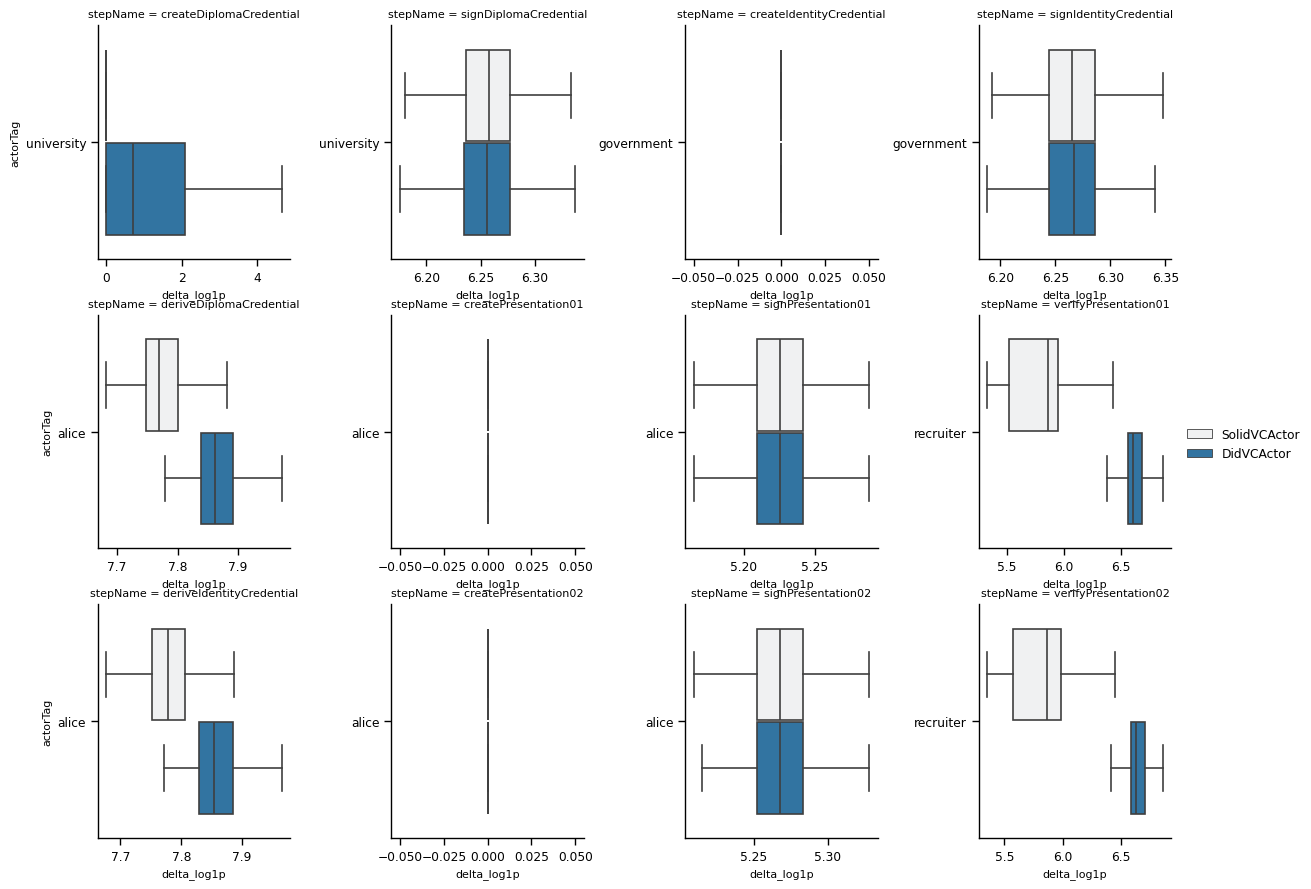

In [195]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x=VAR_X,
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{}'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

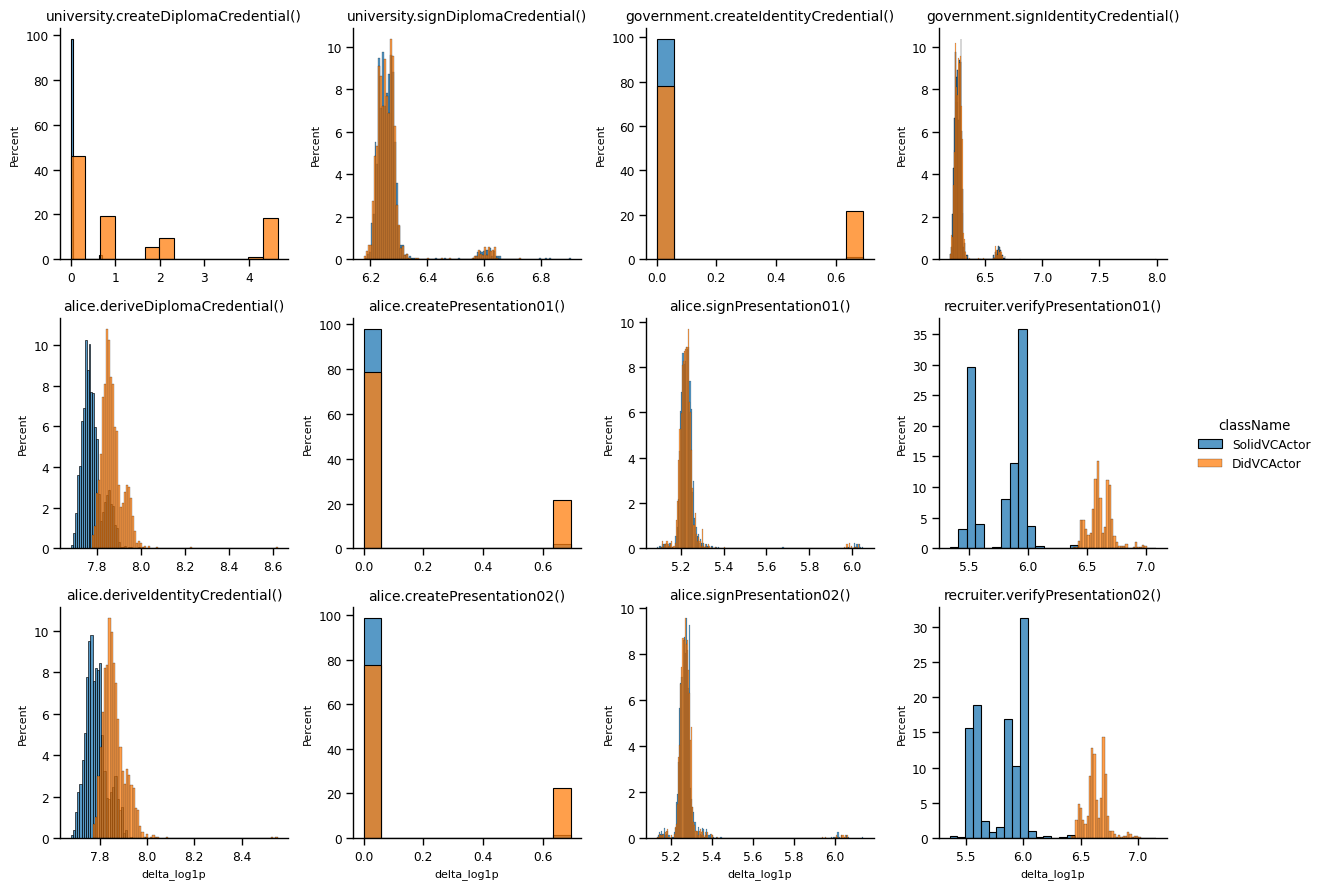

In [226]:
kwargs_fg = dict(col = 'stepName',
                 hue='className',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x=VAR_X,
    stat='percent',
    element='bars',
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl.report)
g = g.map_dataframe(sns.histplot,
                    x=VAR_X,
                    stat='percent',
                    element='bars')
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()


plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'),bbox_inches='tight',bbox_extra_artists=[suptitle])
plt.show()

In [227]:
df_tl.report.groupby(['phase','actorTag','className','actorStep'])[['delta']].agg(['mean']).unstack('className')

delta             
                                                                      mean             
className                                                       DidVCActor SolidVCActor
phase          actorTag   actorStep                                                    
phase-1        alice      alice.createPresentation01              0.214153     0.020484
                          alice.deriveDiplomaCredential        2621.913718  2390.338920
                          alice.signPresentation01              187.129112   187.084420
               recruiter  recruiter.verifyPresentation01        752.358163   327.854128
phase-2        alice      alice.createPresentation02              0.223464     0.014898
                          alice.deriveIdentityCredential       2598.563004  2404.081937
                          alice.signPresentation02              195.468653   195.196772
               recruiter  recruiter.verifyPresentation02        765.410304   338.214773
pre-evaluation government government.createIdentityCredential     0.218498     0.008690
                          government.signIdentityCredential     534.679081   533.059590
               university university.createDiplomaCredential     17.406580     0.018001
                          university.signDiplomaCredential      528.199255   529.326505

In [228]:
# TODO: REFACTOR
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

## Statistics

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [229]:
p_thresh = .05

In [230]:
steps = df_tl.report.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [231]:
grpr_className = df_tl.report.groupby('className')
assert grpr_className.ngroups == 2 # sanity check
A,B = grpr_className

In [237]:
_var = VAR_X
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        if np.shape(a) != np.shape(b):
            print(np.shape(a), np.shape(b))
        assert np.shape(a) == np.shape(b)

        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference (p<{p_thresh}) in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results.to_csv(os.path.join(DIR_REPORT, 'df_significance-tests.csv'))
df_test_results


    Group A: DidVCActor
    Group B: SolidVCActor
    Tested variable: delta_log1p



,tvalue,pvalue,df,_alternative,_standard_error,_estimate,REJECT_H0,Conclusion
createDiplomaCredential,30.673773,1.698565e-181,3220.0,0.0,0.042083,1.290855,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"
signDiplomaCredential,-0.678969,4.972063e-01,3220.0,0.0,0.002697,-0.001831,False,"No significant difference in ""delta_log1p"" between DidVCActor and SolidVCActor"
createIdentityCredential,19.877313,5.016194e-83,3220.0,0.0,0.007316,0.145428,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"
signIdentityCredential,0.450521,6.523651e-01,3220.0,0.0,0.002820,0.001270,False,"No significant difference in ""delta_log1p"" between DidVCActor and SolidVCActor"
deriveDiplomaCredential,54.928522,0.000000e+00,3220.0,0.0,0.001679,0.092244,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"
createPresentation01,17.905332,2.005435e-68,3220.0,0.0,0.007497,0.134241,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"
signPresentation01,0.184595,8.535583e-01,3220.0,0.0,0.002914,0.000538,False,"No significant difference in ""delta_log1p"" between DidVCActor and SolidVCActor"
verifyPresentation01,143.771148,0.000000e+00,3220.0,0.0,0.005880,0.845408,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"
deriveIdentityCredential,45.771198,0.000000e+00,3220.0,0.0,0.001692,0.077455,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"
createPresentation02,19.290481,1.485063e-78,3220.0,0.0,0.007494,0.144567,True,"Significant difference (p<0.05) in ""delta_log1p"" between DidVCActor and SolidVCActor"


In [238]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(list(steps_with_sig_diff))

['createDiplomaCredential', 'createIdentityCredential', 'deriveDiplomaCredential', 'createPresentation01', 'verifyPresentation01', 'deriveIdentityCredential', 'createPresentation02', 'verifyPresentation02']


In [239]:
df_tl_sig_diff = df_tl.report[df_tl.report.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(25776, 9)

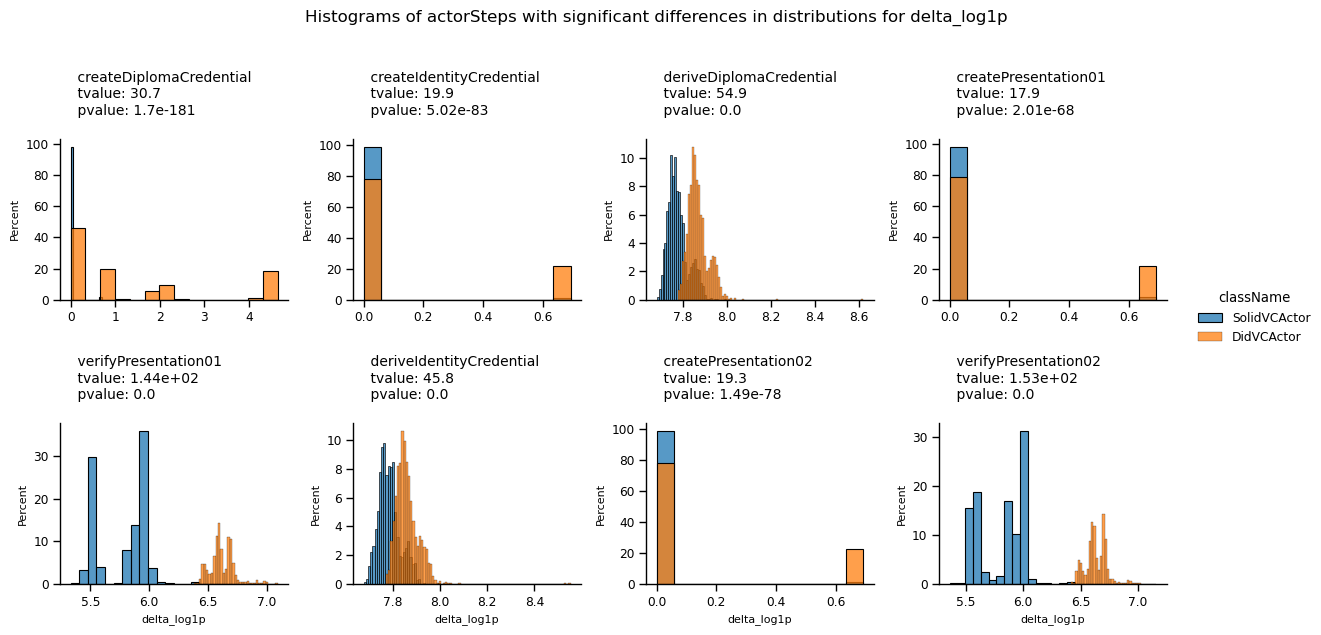

In [240]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False, col_wrap=4)
g = g.map_dataframe(sns.histplot,
                    x=VAR_X,
                    stat='percent',
                    element='bars')
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')
    
g.tight_layout()
suptitle = plt.suptitle(f'Histograms of actorSteps with significant differences in distributions for {VAR_X}',y=1.05)
plt.show()

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [241]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [244]:
_var = 'delta_log1p'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        

colname_effect_size =f'cohend_{k_a}_{k_b}__{_var}'
s_effect_sizes = pd.Series(effect_size_per_step, name=colname_effect_size)

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
def create_explanation(r) -> str:
    es = r[colname_effect_size]
    pos = es > 0
    ec = r.effect_class
    
    return f'The mean of {k_a} is {"greater" if pos else "smaller"} than the mean of {k_b}, with effect size: {es} (which can be classified as {ec}).'
df_effect_sizes['explanation'] = df_effect_sizes.apply(create_explanation, axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))
df_effect_sizes

,cohend_DidVCActor_SolidVCActor__delta_log1p,effect_class,explanation
createDiplomaCredential,1.080773,LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.0807728471248015 (which can be classified as LARGE)."
signDiplomaCredential,-0.023923,VERY_SMALL,"The mean of DidVCActor is smaller than the mean of SolidVCActor, with effect size: -0.023923086355168335 (which can be classified as VERY_SMALL)."
createIdentityCredential,0.700366,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.7003657426658256 (which can be classified as MEDIUM)."
signIdentityCredential,0.015874,VERY_SMALL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.01587384994798249 (which can be classified as VERY_SMALL)."
deriveDiplomaCredential,1.935375,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.9353750560549572 (which can be classified as VERY_LARGE)."
createPresentation01,0.630884,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6308841479017578 (which can be classified as MEDIUM)."
signPresentation01,0.006504,NIHIL,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.006504101508290548 (which can be classified as NIHIL)."
verifyPresentation01,5.065694,HUGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 5.065694180002759 (which can be classified as HUGE)."
deriveIdentityCredential,1.612722,VERY_LARGE,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 1.6127219828890706 (which can be classified as VERY_LARGE)."
createPresentation02,0.679689,MEDIUM,"The mean of DidVCActor is greater than the mean of SolidVCActor, with effect size: 0.6796890528600683 (which can be classified as MEDIUM)."


/var/folders/tf/j9ycytm53pzbs56ftdt8rp_w0000gn/T/ipykernel_15488/1671008354.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)


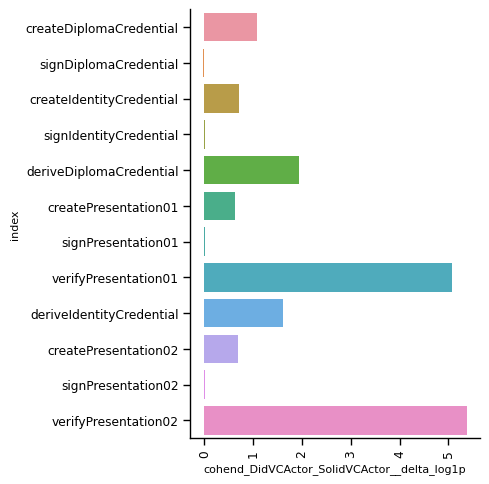

In [245]:
g= sns.catplot(df_effect_sizes.reset_index(),y='index',x=colname_effect_size, kind='bar',orient='h')
g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=90)
plt.show()

---
### WIP: analyze effects of document loader cache option configurations

In [65]:
df_tl[('dlco','code')] = df_tl.dlco.astype(int).apply(list,axis=1).apply(enumerate).apply(lambda a: map(lambda e: (2**e[0]+1)*e[1], a)).apply(list).apply(pd.Series).sum(axis=1)

In [351]:
df_tl.dlco.groupby('code').count()

,DID_cacheResolvedDIDDocs,HTTP_cacheWebResourcesResolvedFromLocalHostInstances,HTTP_cacheWebResourcesResolvedFromTheWeb
code,,,
0,12000,12000,12000
83,12000,12000,12000
412,12000,12000,12000
577,2676,2676,2676


In [354]:
snsdata = df_tl.filter(regex='idx|delta|code|class|actor').set_index(['idx_report','idx_step']).droplevel(0,axis=1).reset_index()
snsdata.head()

,idx_report,idx_step,actorStep,actorTag,className,delta,delta_log1p,code
0,0,0,university.createDiplomaCredential,university,SolidVCActor,0,0.0,0
1,1,0,university.createDiplomaCredential,university,SolidVCActor,0,0.0,0
2,2,0,university.createDiplomaCredential,university,SolidVCActor,0,0.0,0
3,3,0,university.createDiplomaCredential,university,DidVCActor,0,0.0,0
4,4,0,university.createDiplomaCredential,university,SolidVCActor,0,0.0,0


In [356]:
df_tl.dlco.groupby('code').first().stack()

code                                                      
0     DID_cacheResolvedDIDDocs                                False
      HTTP_cacheWebResourcesResolvedFromLocalHostInstances    False
      HTTP_cacheWebResourcesResolvedFromTheWeb                False
83    DID_cacheResolvedDIDDocs                                 True
      HTTP_cacheWebResourcesResolvedFromLocalHostInstances    False
      HTTP_cacheWebResourcesResolvedFromTheWeb                False
412   DID_cacheResolvedDIDDocs                                 True
      HTTP_cacheWebResourcesResolvedFromLocalHostInstances    False
      HTTP_cacheWebResourcesResolvedFromTheWeb                 True
577   DID_cacheResolvedDIDDocs                                 True
      HTTP_cacheWebResourcesResolvedFromLocalHostInstances     True
      HTTP_cacheWebResourcesResolvedFromTheWeb                 True
dtype: object

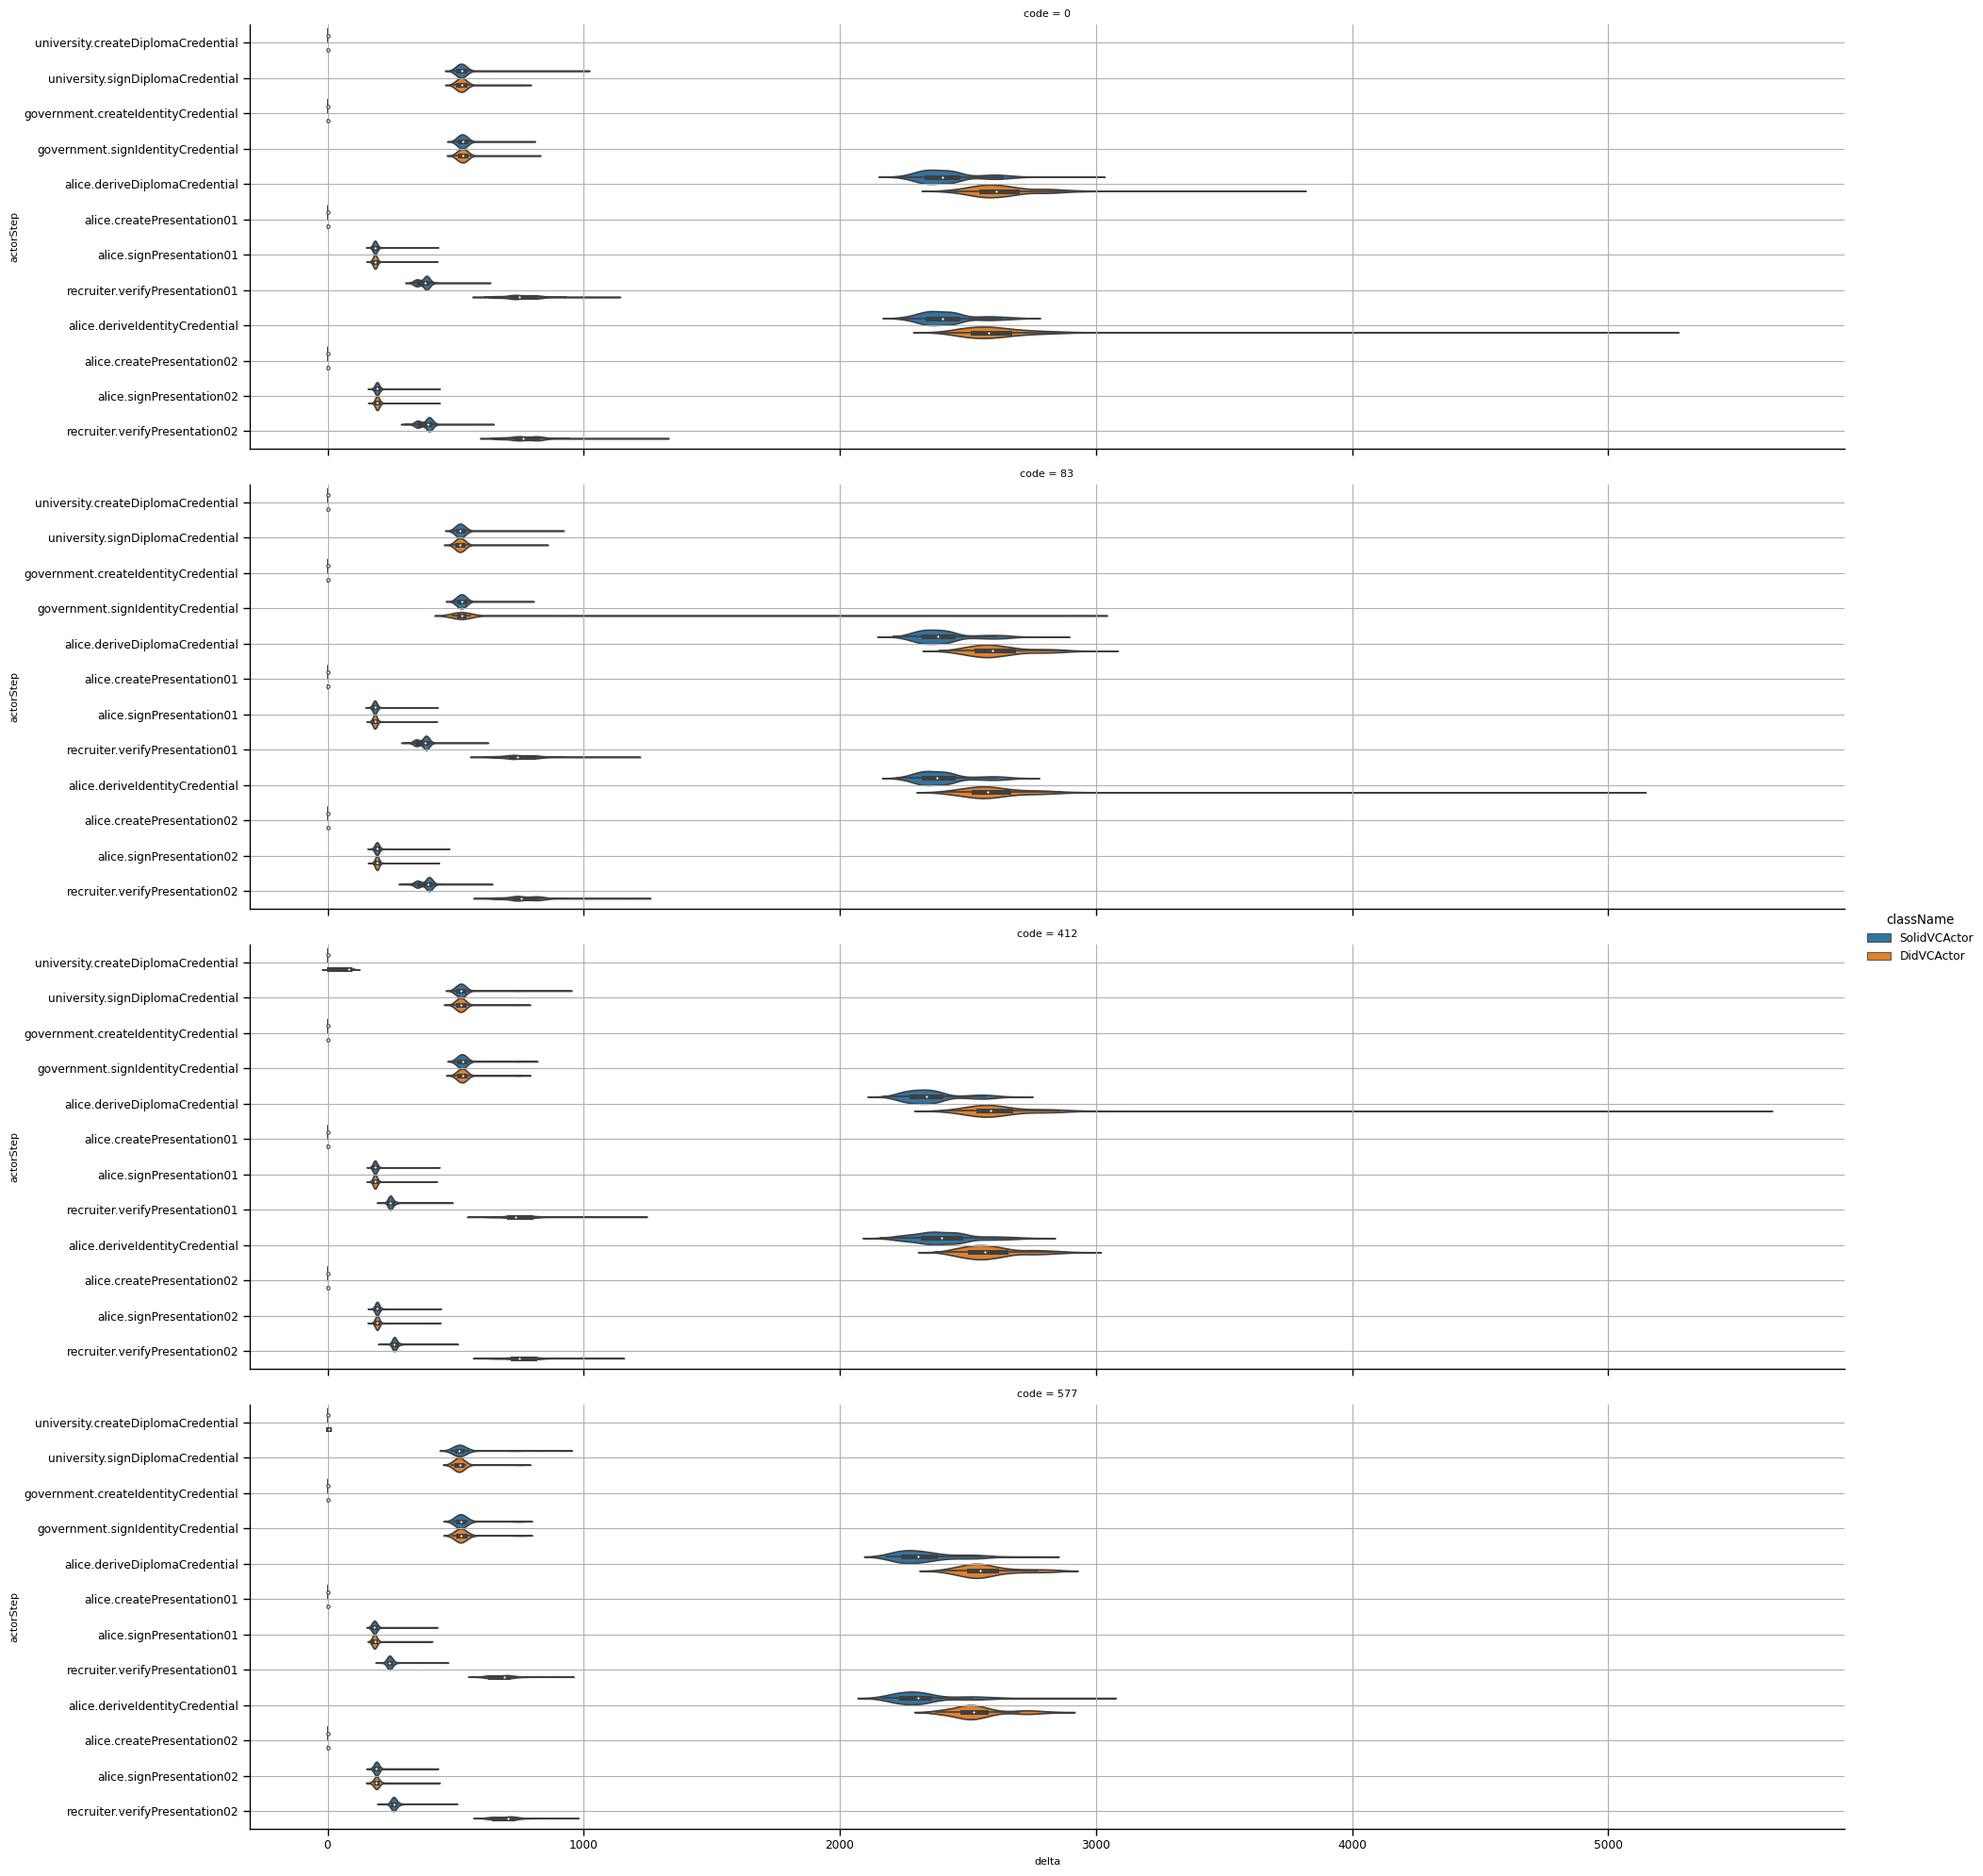

In [357]:
g = sns.catplot(data=snsdata,x='delta',y='actorStep',hue='className', row='code',aspect=4, kind='violin')
for ax in g.axes.ravel():
    ax.grid()

Text(0.5, 1.0, "{'DID_cacheResolvedDIDDocs': True, 'HTTP_cacheWebResourcesResolvedFromLocalHostInstances': True, 'HTTP_cacheWebResourcesResolvedFromTheWeb': True}")

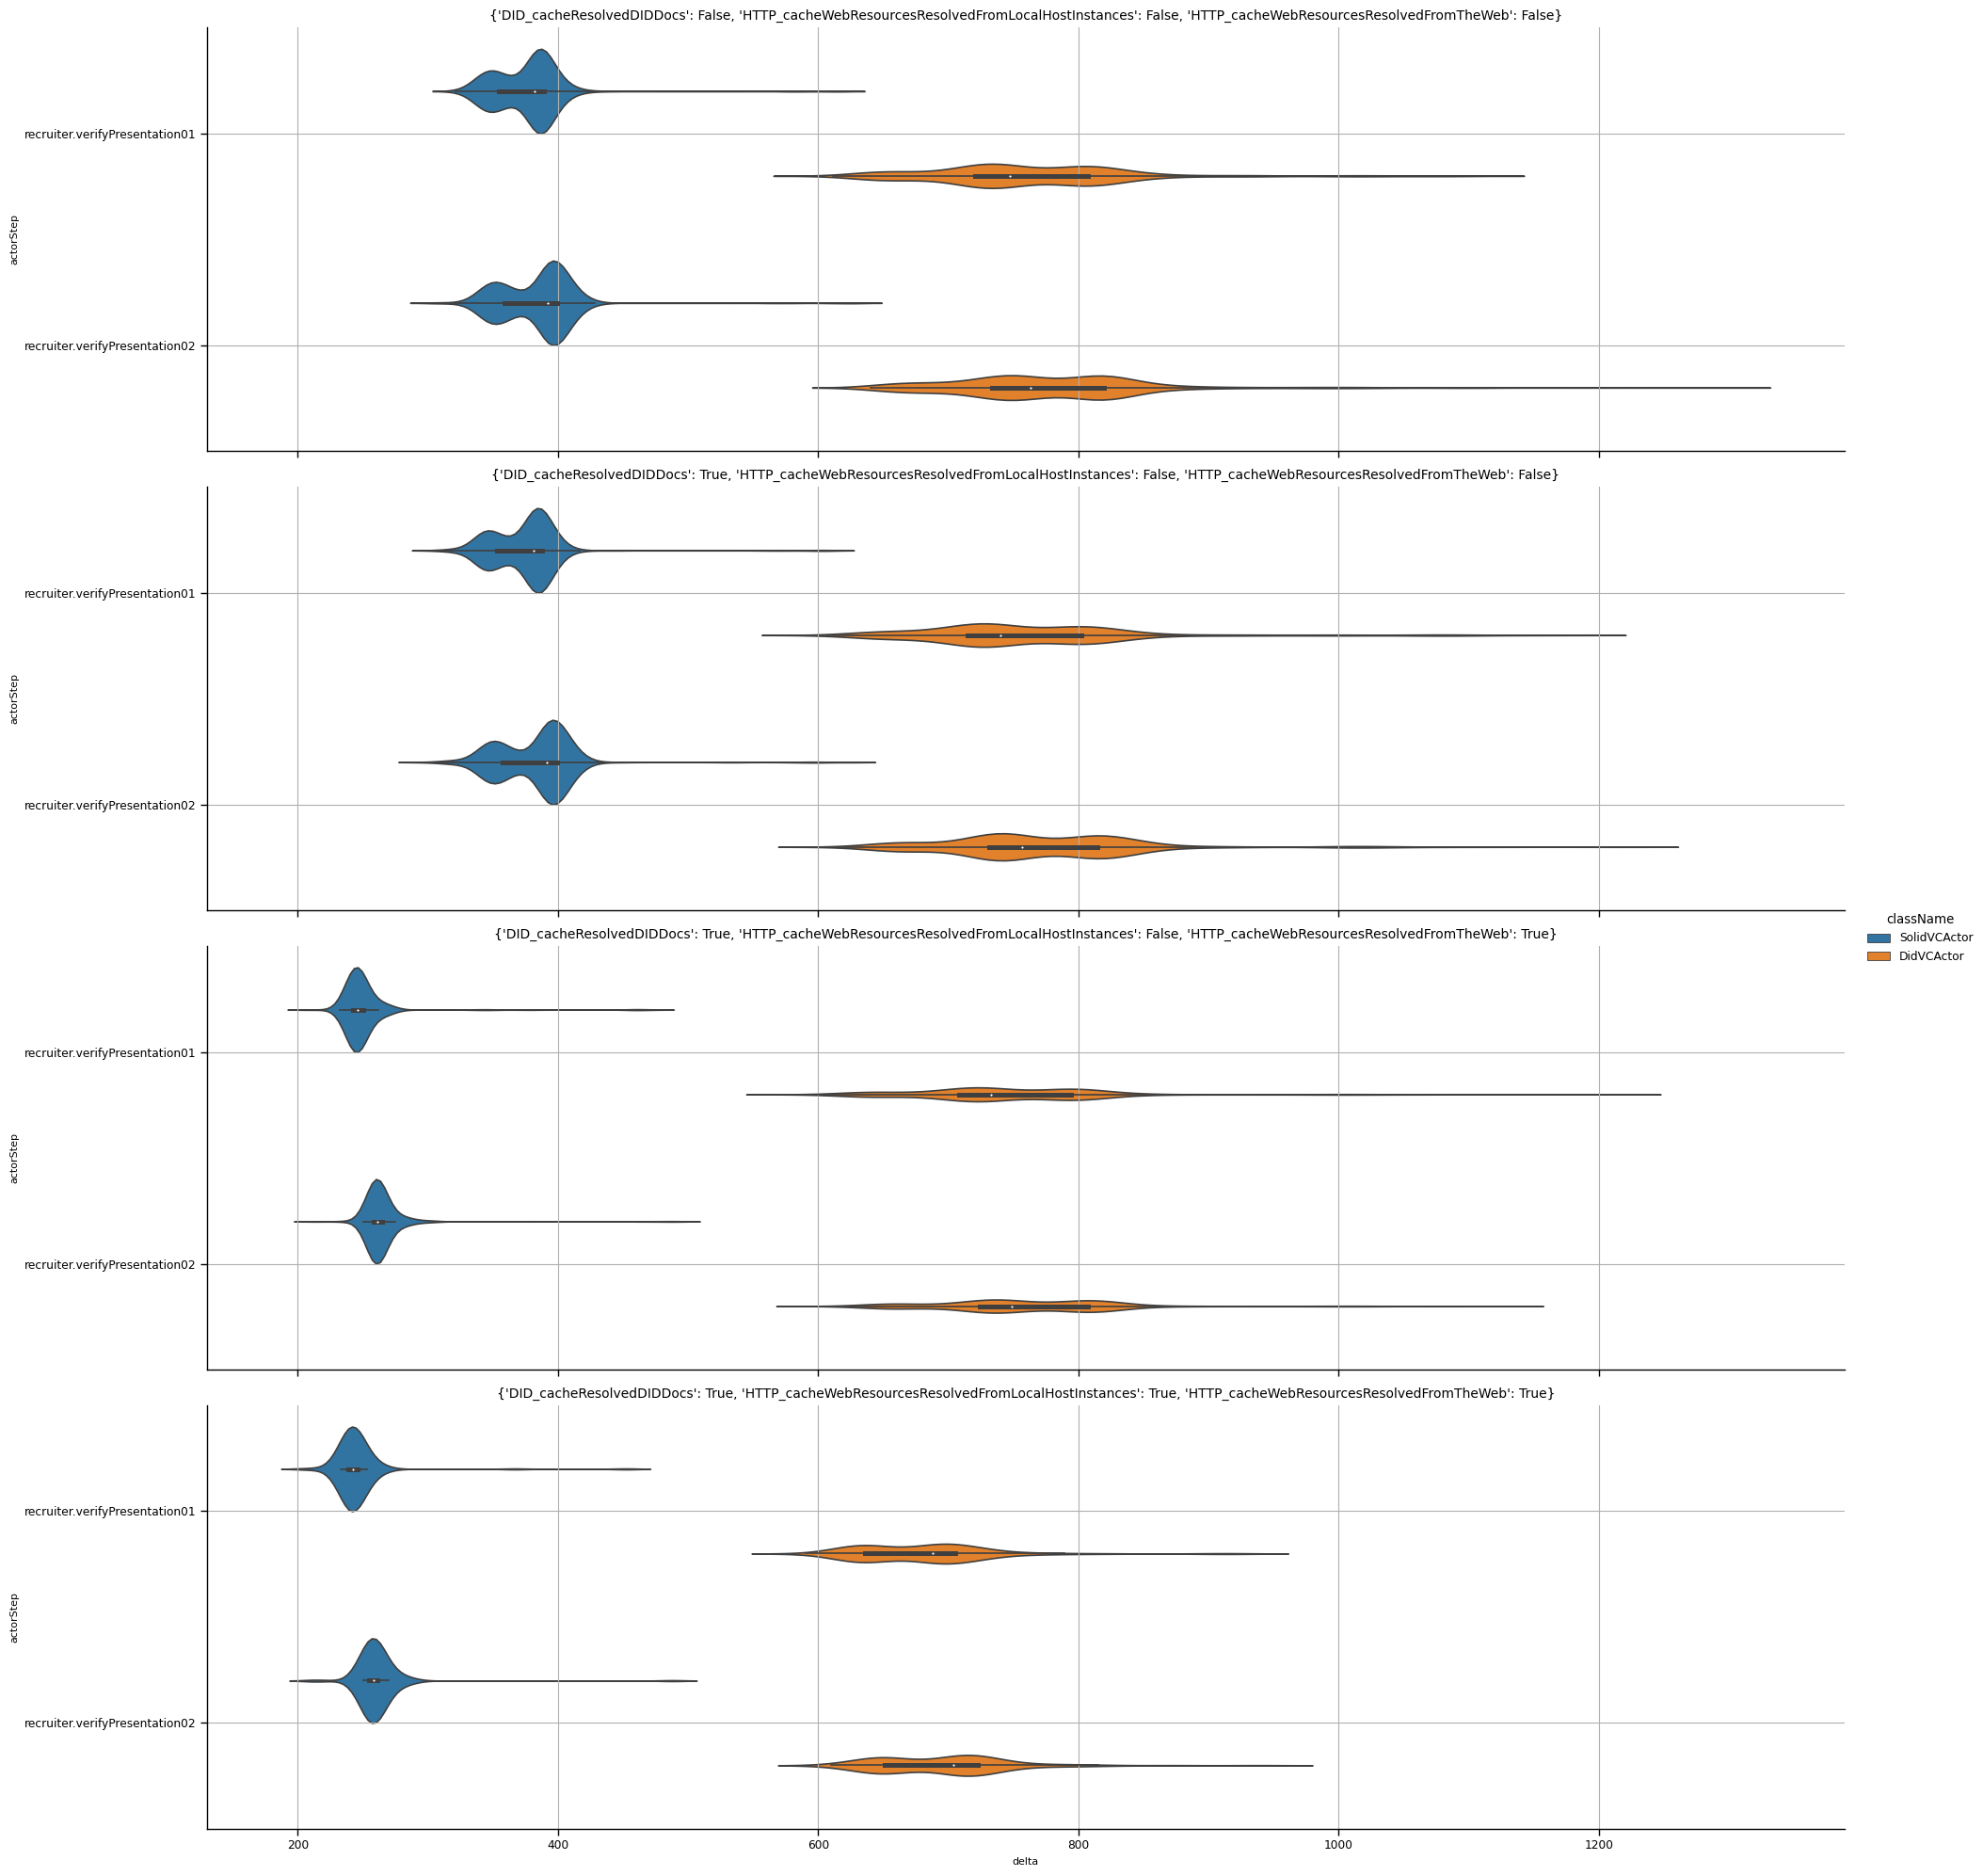

In [369]:
g = sns.catplot(data=snsdata[snsdata.actorStep.str.contains('verify')],x='delta',y='actorStep',hue='className', row='code',aspect=4, kind='violin')
for ax in g.axes.ravel():
    ax.grid()
for k, ax in g.axes_dict.items():
    ax.set_title(df_tl.dlco.groupby('code').first().stack().loc[k].to_dict())

---